In [1]:
import numpy as np
import os

dir_name = 'lotka_volterra'
file_stem = 'lotkavolterra'  # 저장 시 이렇게 저장되었음

def load_dataset(dir_name, file_stem=None):
    if file_stem is None:
        file_stem = dir_name.replace('_', '')  # 기본 룰 적용
    path = os.path.join('..', 'generated', dir_name, f'{file_stem}_dataset.npz')
    # Python 객체가 포함되어 있으므로 allow_pickle=True 필요
    return np.load(path, allow_pickle=True)

# 로드
data = load_dataset(dir_name, file_stem)

# 내용 확인
print(data.files)  # 예: ['params', 'x0', 'samples', 'time_steps', 'sols', 'dt', 'system_type']

# 예시 접근
params = data['params']        # shape: (10000, param_dim)
x0 = data['x0']                # shape: (10000, state_dim)
samples = data['samples']      # shape: (10000, T, D)
time_steps = data['time_steps']  # shape: (10000, T)
sols = data['sols']            # 리스트 형태로 저장된 solve_ivp 객체들


['params', 'x0', 'samples', 'time_steps', 'sols', 'dt', 'system_type']


In [2]:
import numpy as np
import pandas as pd
def convert_npz_to_dataframe(npz_data):
    """
    npz 데이터를 compact하게 sample 단위로 요약한 DataFrame을 생성합니다.
    각 sample은 하나의 row로, 
      - 관측 시계열 ('samples')와 time grid ('time_steps')는 list로,
      - 초기 조건 ('x0'), 파라미터 ('params'),
      - 그리고 ground truth trajectory (solve_ivp 객체의 y.T, 'sols')가 저장됩니다.
    """
    import pandas as pd
    
    params = npz_data['params']         # shape: (N, P)
    x0 = npz_data['x0']                 # shape: (N, D)
    samples = npz_data['samples']       # shape: (N, T, D)
    time_steps = npz_data['time_steps'] # shape: (N, T)
    sols = npz_data['sols']             # list of solve_ivp objects, 길이 N
    
    N, T, D = samples.shape
    records = []
    for i in range(N):
        # true trajectory는 각 solve_ivp 객체의 y.T (shape: (T_full, D))를 리스트로 변환
        try:
            true_traj = sols[i].y.T.tolist()  
        except Exception as e:
            true_traj = None
        
        row = {
            'sample_idx': i,
            'x0': list(x0[i]),
            'params': list(params[i]),
            'times': list(time_steps[i]),
            'true_trajectory': true_traj  # ground truth trajectory
        }
        # 각 상태 변수에 대한 관측 시계열 (noisy observations)
        for d in range(D):
            row[f'state_{d}'] = list(samples[i, :, d])
        records.append(row)
    
    df = pd.DataFrame(records)
    return df

In [3]:
df = convert_npz_to_dataframe(data)

df

,sample_idx,x0,params,times,true_trajectory,state_0,state_1
0,0,"[9.49816047538945, 5.901428612819832]","[1.092797576724562, 0.10394633936788146, 0.064...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.49816047538945, 5.901428612819832], [9.984...","[9.81400303849093, 23.820310985254146, 38.1766...","[6.054915558650414, 3.9254945106096795, 15.330..."
1,1,"[8.798695128633439, 5.028468876827223]","[1.036965827544817, 0.08185801650879991, 0.065...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[8.798695128633439, 5.028468876827223], [9.38...","[8.678567390649677, 26.859757077121937, 57.173...","[4.970130126868568, 2.7361512889073656, 18.912..."
2,2,"[9.554709158757928, 4.542698063547792]","[1.1314950036607718, 0.09427013306774357, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.554709158757928, 4.542698063547792], [10.2...","[9.619525952636888, 28.957527795169433, 23.387...","[4.4656816074645285, 4.469653296971071, 28.371..."
3,3,"[11.548850970305306, 4.944429850323899]","[0.8478376983753207, 0.1085297914889198, 0.076...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.548850970305306, 4.944429850323899], [11....","[11.541685762483317, 22.448197486321202, 38.24...","[5.2573585814867005, 2.911255710608391, 8.8830..."
4,4,"[11.214688307596457, 4.3731401177720715]","[1.1570235993959912, 0.10157368967662603, 0.08...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.214688307596457, 4.3731401177720715], [12...","[11.074277688820986, 33.87231650253858, 15.072...","[4.307607688452518, 4.835836669578541, 26.3914..."
...,...,...,...,...,...,...,...
9995,9995,"[9.06674222472362, 5.3645536793597985]","[0.9480434487307816, 0.08078143951745678, 0.08...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[9.06674222472362, 5.3645536793597985], [9.56...","[9.060958052312612, 23.83030903981786, 39.8795...","[5.196456735516876, 2.5995442412260426, 19.755..."
9996,9996,"[10.686058521731491, 4.239487630890881]","[1.0278582369298326, 0.09260471597377619, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[10.686058521731491, 4.239487630890881], [11....","[10.811219441088685, 28.16398830048308, 22.769...","[4.462505947047643, 4.874626080613738, 24.3013..."
9997,9997,"[10.65100326033214, 5.273218015173407]","[0.838361935376518, 0.11046376636499679, 0.064...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[10.65100326033214, 5.273218015173407], [10.9...","[10.61096153260883, 18.956532493649554, 32.991...","[5.4727168018515835, 3.663571098487103, 6.0885..."
9998,9998,"[11.919242342013689, 5.0723115827422385]","[1.0752165747222993, 0.08828518687956767, 0.07...","[0.0, 1.4285714285714286, 2.857142857142857, 4...","[[11.919242342013689, 5.0723115827422385], [12...","[11.653639391931149, 29.769390760639084, 19.65...","[5.072443068170984, 6.646510368944044, 25.6346..."


In [11]:
def split_dataframe(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=None):
    """
    각 sample이 row인 DataFrame을 train, validation, test set으로 분할합니다.
    이 DataFrame은 관측 시계열, 실제(ground truth) trajectory, 초기조건, 파라미터 등의 정보를 포함합니다.
    
    Args:
        df (pd.DataFrame): 전체 데이터셋 (각 row가 하나의 sample)
        train_ratio (float): 학습 데이터 비율
        val_ratio (float): 검증 데이터 비율
        test_ratio (float): 테스트 데이터 비율
        seed (int, optional): 랜덤 시드
        
    Returns:
        tuple: (train_df, val_df, test_df)
    """
    import pandas as pd
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9, "비율의 합은 1이어야 합니다"
    
    if seed is not None:
        df_shuffled = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
    
    n = len(df_shuffled)
    train_end = int(train_ratio * n)
    val_end = train_end + int(val_ratio * n)
    
    train_df = df_shuffled.iloc[:train_end].reset_index(drop=True)
    val_df = df_shuffled.iloc[train_end:val_end].reset_index(drop=True)
    test_df = df_shuffled.iloc[val_end:].reset_index(drop=True)
    
    return train_df, val_df, test_df


In [12]:
train_df, val_df, test_df = split_dataframe(df, seed=42)

In [13]:
def extract_timeseries_and_params(df):
    """
    compact dataframe에서 (시계열, 파라미터) 쌍 리스트 추출
    Returns:
        List[Tuple[np.ndarray, np.ndarray]]
    """
    data = []
    for _, row in df.iterrows():
        # 하나의 시계열: 모든 state 차원을 하나로 concat → shape (T, D)
        states = np.stack([row[f'state_{d}'] for d in range(len(row['x0']))], axis=1)
        params = np.array(row['params'])  # shape: (param_dim,)
        data.append((states, params))
    return data

In [18]:
train_data = extract_timeseries_and_params(train_df)
val_data = extract_timeseries_and_params(val_df)
test_data = extract_timeseries_and_params(test_df)

In [19]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeseriesParamDataset(Dataset):
    def __init__(self, data):
        """
        data: List of tuples (timeseries, params)
            - timeseries: numpy array of shape (T, D)
            - params: numpy array of shape (param_dim,)
        """
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        timeseries, params = self.data[idx]
        return {
            'timeseries': torch.tensor(timeseries, dtype=torch.float32),
            'params': torch.tensor(params, dtype=torch.float32)
        }


def create_dataloaders(train_data, val_data, test_data, batch_size=64, shuffle=True):
    train_dataset = TimeseriesParamDataset(train_data)
    val_dataset = TimeseriesParamDataset(val_data)
    test_dataset = TimeseriesParamDataset(test_data)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [20]:
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data)

# 한 배치 예시 보기
for batch in train_loader:
    print(batch['timeseries'].shape)  # (B, T, D)
    print(batch['params'].shape)      # (B, param_dim)
    break


torch.Size([64, 8, 2])
torch.Size([64, 4])


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Timeseries Encoder: 시계열에서 latent 조건 벡터 추출
class TimeseriesEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TimeseriesEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        # x: shape (B, T, input_dim)
        out, (hn, _) = self.lstm(x)  # hn: (num_layers, B, hidden_dim)
        # 마지막 layer의 hidden state 사용
        z = self.fc(hn[-1])  # shape: (B, latent_dim)
        return z

# 2. Conditional RNN: 시계열 재구성 (조건 벡터를 각 시점의 입력에 붙임)
class ConditionalRNN(nn.Module):
    def __init__(self, input_dim, cond_dim, hidden_dim, output_dim, num_layers=1):
        super(ConditionalRNN, self).__init__()
        # 입력 차원은 기존 input_dim + cond_dim
        self.lstm = nn.LSTM(input_dim + cond_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, cond):
        # x: shape (B, T, input_dim)
        # cond: shape (B, cond_dim) → 이를 T번 반복해서 concat할 수 있음
        B, T, _ = x.size()
        cond_expanded = cond.unsqueeze(1).repeat(1, T, 1)  # shape: (B, T, cond_dim)
        x_cond = torch.cat([x, cond_expanded], dim=2)  # shape: (B, T, input_dim+cond_dim)
        out, _ = self.lstm(x_cond)  # out: (B, T, hidden_dim)
        output = self.fc(out)       # output: (B, T, output_dim)
        return output

# 3. 전체 모델: 인코더와 Conditional RNN을 결합
class RNNParameterEstimationModel(nn.Module):
    def __init__(self, input_dim, encoder_hidden_dim, latent_dim, rnn_hidden_dim, output_dim, num_layers=1):
        super(RNNParameterEstimationModel, self).__init__()
        self.encoder = TimeseriesEncoder(input_dim, encoder_hidden_dim, latent_dim, num_layers)
        self.decoder = ConditionalRNN(input_dim, latent_dim, rnn_hidden_dim, output_dim, num_layers)
    
    def forward(self, x):
        # x: (B, T, input_dim) -> 관측된 시계열 (noisy)
        cond = self.encoder(x)           # 추출된 조건 벡터, shape: (B, latent_dim)
        output = self.decoder(x, cond)   # 재구성된 시계열, shape: (B, T, output_dim)
        return output, cond


In [23]:

# 4. 손실 함수 정의 (Reconstruction Loss + Prior Loss)
def reconstruction_loss(pred, target):
    # pred, target: (B, T, output_dim)
    return torch.mean((pred - target) ** 2)

def prior_loss(latent, mu=0.0, sigma=1.0):
    # latent: (B, latent_dim)라고 가정하고, L2 정규화로 prior loss 구성
    return torch.mean(((latent - mu)/sigma) ** 2)


In [28]:
# 5. 학습 루프 (예시)
import torch
import torch.optim as optim
from tqdm import tqdm

def train_rnn_model(
    model, 
    train_loader, 
    val_loader=None, 
    num_epochs=1000, 
    lr=1e-3, 
    lambda_prior=0.1, 
    device='cuda', 
    early_stopping_patience=20
):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # 학습률 스케줄러 (validation loss가 개선되지 않으면 학습률 감소)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)
    
    best_val_loss = float('inf')
    no_improve_epochs = 0
    
    train_losses = []
    val_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Epochs'):
        model.train()
        epoch_loss = 0.0
        
        # tqdm으로 배치 진행 상황 모니터링
        for batch in train_loader:
            x = batch['timeseries'].to(device)  # (B, T, input_dim)
            true_params = batch.get('params')
            if true_params is not None:
                true_params = true_params.to(device)
            
            optimizer.zero_grad()
            pred, cond = model(x)  # pred: (B, T, output_dim), cond: (B, latent_dim)
            
            rec_loss = reconstruction_loss(pred, x)  # reconstruction loss (MSE)
            loss = rec_loss
            
            # 지도 정보가 있는 경우, 조건 벡터와 실제 파라미터 사이의 L2 loss 추가
            if true_params is not None:
                loss += lambda_prior * reconstruction_loss(cond, true_params)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item() * x.size(0)
        
        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)
        
        # validation 평가 (val_loader가 제공된 경우)
        if val_loader is not None:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    x_val = batch['timeseries'].to(device)
                    true_params_val = batch.get('params')
                    if true_params_val is not None:
                        true_params_val = true_params_val.to(device)
                    
                    pred_val, cond_val = model(x_val)
                    loss_val = reconstruction_loss(pred_val, x_val)
                    if true_params_val is not None:
                        loss_val += lambda_prior * reconstruction_loss(cond_val, true_params_val)
                    
                    val_loss += loss_val.item() * x_val.size(0)
            avg_val_loss = val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)
            #print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
            
            # 학습률 스케줄러 업데이트
            scheduler.step(avg_val_loss)
            
            # Early stopping 확인
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                no_improve_epochs = 0
                # 만약 필요하다면 best model checkpoint 저장
                best_model_state = model.state_dict()
            else:
                no_improve_epochs += 1
            
            if no_improve_epochs >= early_stopping_patience:
                print("Early stopping triggered.")
                break
        else:
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")
    
    # 필요하다면 best model state 로 복원
    if val_loader is not None and 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    # 학습 곡선 시각화 (원하는 경우)
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 5))
        plt.plot(train_losses, label='Train Loss')
        if val_loader is not None:
            plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Learning Curves')
        plt.legend()
        plt.show()
    except Exception as e:
        print("Plotting failed:", e)
    
    return model, train_losses, val_losses


Epochs:  10%|█         | 207/2000 [01:14<12:02,  2.48it/s]

Epoch 00207: reducing learning rate of group 0 to 5.0000e-04.


Epochs:  13%|█▎        | 255/2000 [01:34<10:15,  2.84it/s]

Epoch 00255: reducing learning rate of group 0 to 2.5000e-04.


Epochs:  13%|█▎        | 269/2000 [01:40<10:43,  2.69it/s]

Epoch 00269: reducing learning rate of group 0 to 1.2500e-04.


Epochs:  19%|█▊        | 372/2000 [02:27<12:58,  2.09it/s]

Epoch 00372: reducing learning rate of group 0 to 6.2500e-05.


Epochs:  20%|█▉        | 396/2000 [02:38<12:32,  2.13it/s]

Epoch 00396: reducing learning rate of group 0 to 3.1250e-05.


Epochs:  21%|██        | 423/2000 [02:51<12:29,  2.10it/s]

Epoch 00423: reducing learning rate of group 0 to 1.5625e-05.


Epochs:  22%|██▏       | 444/2000 [03:01<12:37,  2.05it/s]

Epoch 00444: reducing learning rate of group 0 to 7.8125e-06.


Epochs:  26%|██▌       | 522/2000 [03:38<11:34,  2.13it/s]

Epoch 00522: reducing learning rate of group 0 to 3.9063e-06.


Epochs:  27%|██▋       | 543/2000 [03:48<11:42,  2.07it/s]

Epoch 00543: reducing learning rate of group 0 to 1.9531e-06.


Epochs:  30%|███       | 604/2000 [04:15<11:07,  2.09it/s]

Epoch 00604: reducing learning rate of group 0 to 9.7656e-07.


Epochs:  32%|███▏      | 633/2000 [04:29<10:45,  2.12it/s]

Epoch 00633: reducing learning rate of group 0 to 4.8828e-07.


Epochs:  32%|███▏      | 641/2000 [04:33<09:40,  2.34it/s]

Early stopping triggered.


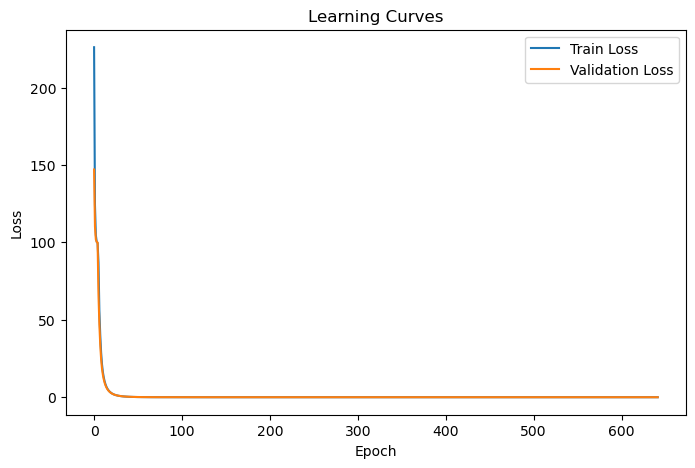

In [29]:

# 하이퍼파라미터 설정
input_dim = 2         # 상태 변수 차원 (예: Lotka-Volterra의 prey, predator)
encoder_hidden_dim = 32
latent_dim = 4        # 파라미터 차원과 동일하게 설정
rnn_hidden_dim = 64
output_dim = 2        # 복원된 시계열의 차원

# 모델 초기화
model = RNNParameterEstimationModel(
    input_dim=input_dim,
    encoder_hidden_dim=encoder_hidden_dim,
    latent_dim=latent_dim,
    rnn_hidden_dim=rnn_hidden_dim,
    output_dim=output_dim,
    num_layers=2
)

# 학습 실행
trained_model, train_losses, val_losses = train_rnn_model(
    model,
    train_loader,
    val_loader,
    num_epochs=2000,
    lr=1e-3,
    lambda_prior=0.1,
    device='cuda'  # GPU 사용 시 'cuda'로 변경
)

In [49]:
import torch
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device='cuda'):
    model.eval()
    total_rec_loss = 0.0
    total_param_loss = 0.0
    count = 0  # 전체 배치의 샘플 수 누적

    with torch.no_grad():
        for batch in dataloader:
            # 배치 데이터 로딩
            x_obs = batch['timeseries'].to(device)      # (B, T_obs, state_dim)
            true_params = batch['params'].to(device)      # (B, param_dim)

            # 모델 예측: reconstruction 및 parameter proxy 추출
            pred_obs, cond = model(x_obs)                # pred_obs: (B, T_obs, output_dim), cond: (B, latent_dim)
            
            # 1. Reconstruction Loss (noisy 관측 시계열과 재구성 시계열 간 MSE)
            rec_loss = torch.mean((pred_obs - x_obs) ** 2)
            total_rec_loss += rec_loss.item() * x_obs.size(0)
            
            # 2. Parameter Estimation Loss (추정된 조건 벡터와 ground truth 파라미터 간 MSE)
            param_loss = torch.mean((cond - true_params) ** 2)
            total_param_loss += param_loss.item() * x_obs.size(0)
            
            # 각 배치의 샘플 수 누적
            count += x_obs.size(0)
    
    avg_rec_loss = total_rec_loss / count
    avg_param_loss = total_param_loss / count
    
    print(f"Test Reconstruction Loss: {avg_rec_loss:.4f}")
    print(f"Test Parameter Estimation Loss: {avg_param_loss:.4f}")
    
    return avg_rec_loss, avg_param_loss

# 평가 코드 호출 (예시)
evaluate_model(trained_model, test_loader, device='cuda')


Test Reconstruction Loss: 0.0001
Test Parameter Estimation Loss: 0.0013


(0.00012958172380846616, 0.001270742700745662)

In [54]:
import torch
import numpy as np

def extract_true_and_estimated_params(model, dataloader, device='cuda'):
    """
    모델을 이용하여 각 배치의 추정 파라미터 (estimated parameters)를 계산하고,
    dataloader에 포함된 ground truth 파라미터와 함께 numpy 배열로 반환합니다.

    Args:
        model: 학습된 모델 (RNNParameterEstimationModel)
        dataloader: 테스트 데이터셋 DataLoader, 각 batch는 'timeseries'와 'params' key를 포함.
        device: 사용 장치 ('cuda' 또는 'cpu')

    Returns:
        Tuple (true_params, estimated_params), 둘 다 numpy array 형태, shape: (N, param_dim)
    """
    model.eval()
    all_true_params = []
    all_estimated_params = []
    
    with torch.no_grad():
        for batch in dataloader:
            x = batch['timeseries'].to(device)         # (B, T, input_dim)
            true_params = batch['params'].to(device)     # (B, param_dim)
            # 모델의 인코더를 통해 추정한 조건 벡터를 얻음.
            _, cond = model(x)                          # cond: (B, latent_dim)
            
            all_true_params.append(true_params.cpu().numpy())
            all_estimated_params.append(cond.cpu().numpy())
    
    true_params_all = np.concatenate(all_true_params, axis=0)
    estimated_params_all = np.concatenate(all_estimated_params, axis=0)
    return true_params_all, estimated_params_all

import matplotlib.pyplot as plt

def plot_parameter_scatter(true_params, estimated_params, title='True vs. Estimated Parameters'):
    """
    각 파라미터 차원별로, true parameter와 estimated parameter를 y=x 기준으로 scatter plot으로 시각화합니다.
    
    Args:
        true_params: numpy array, shape (N, param_dim)
        estimated_params: numpy array, shape (N, param_dim)
        title: 전체 그래프 제목
    """
    param_dim = true_params.shape[1]
    fig, axes = plt.subplots(1, param_dim, figsize=(5 * param_dim, 4))
    
    if param_dim == 1:
        axes = [axes]
    
    for d in range(param_dim):
        ax = axes[d]
        ax.scatter(true_params[:, d], estimated_params[:, d], alpha=0.6, edgecolor='k')
        # y = x 기준 선: x 범위는 두 배열의 min과 max를 사용
        min_val = min(np.min(true_params[:, d]), np.min(estimated_params[:, d]))
        max_val = max(np.max(true_params[:, d]), np.max(estimated_params[:, d]))
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        ax.set_xlabel(f"True (Param {d+1})")
        ax.set_ylabel(f"Estimated (Param {d+1})")
        ax.set_title(f"Parameter {d+1}")
    
    fig.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


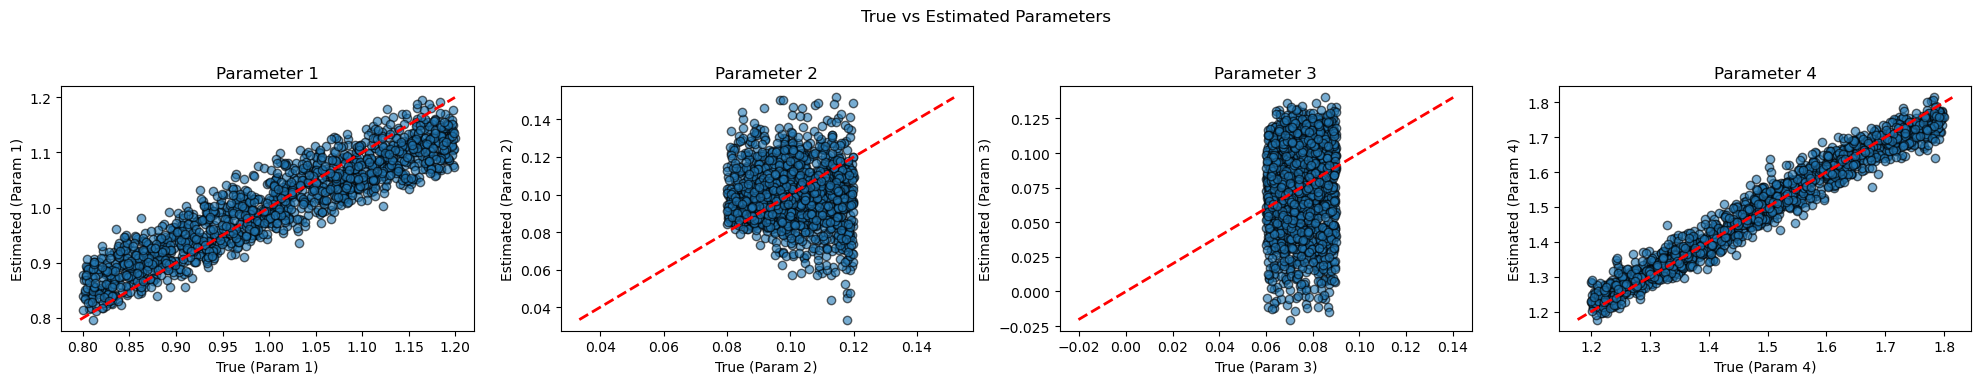

In [55]:
# 예시: 학습된 모델과 test_loader가 준비되었다고 가정
true_params, estimated_params = extract_true_and_estimated_params(trained_model, test_loader, device='cuda')
plot_parameter_scatter(true_params, estimated_params, title='True vs Estimated Parameters')


In [63]:
sample_row = test_df.iloc[0]


# 추출: 관측 시간 및 noisy 관측 데이터
t_obs = np.array(sample_row['times'])  # 관측 시점 (T_obs,)
state_dim = len(sample_row['x0'])
# 각 상태 변수의 noisy 관측 시계열을 불러와 (T_obs, state_dim) 배열로 재구성
obs = np.stack([sample_row[f'state_{d}'] for d in range(state_dim)], axis=1)

# ground truth trajectory: (T_full, state_dim)
true_traj = np.array(sample_row['true_trajectory'])

# 초기 조건 및 ground truth 파라미터
x0 = np.array(sample_row['x0'])
true_params = np.array(sample_row['params'])


In [66]:
obs

array([[11.84216867,  5.27125539],
       [33.5496912 ,  3.61223762],
       [31.70624593, 29.65453796],
       [ 8.68430902, 11.20786701],
       [18.96261358,  3.29380366],
       [48.77107519,  9.02669206],
       [12.12749893, 24.32521081],
       [11.33004627,  5.53668393]])

In [72]:
true_params

array([1.02516235, 0.08336773, 0.07573604, 1.78637666])

In [69]:
x_obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to('cuda')
trained_model.eval()
with torch.no_grad():
    pred_obs_tensor, cond = trained_model(x_obs_tensor)
pred_obs = pred_obs_tensor.squeeze(0).cpu().numpy()  # (T_obs, state_dim)
est_params = cond.squeeze(0).cpu().numpy()           # (latent_dim,)


In [70]:
pred_obs

array([[11.836266 ,  5.2664356],
       [33.567646 ,  3.617302 ],
       [31.708014 , 29.670053 ],
       [ 8.685828 , 11.203618 ],
       [18.953077 ,  3.2982843],
       [48.772438 ,  9.033859 ],
       [12.118741 , 24.321035 ],
       [11.317593 ,  5.5362544]], dtype=float32)

In [71]:
est_params

array([1.040312  , 0.12786174, 0.10830086, 1.7294692 ], dtype=float32)

In [74]:
from scipy.integrate import solve_ivp


def lotka_volterra_eqn(t, x, params):
    """
    Lotka-Volterra 방정식:
        dx/dt = alpha*x - beta*x*y
        dy/dt = delta*x*y - gamma*y
    """
    alpha, beta, delta, gamma = params
    dxdt = alpha * x[0] - beta * x[0] * x[1]
    dydt = delta * x[0] * x[1] - gamma * x[1]
    return [dxdt, dydt]

# 주어진 lotka_volterra_eqn 함수를 그대로 사용한다고 가정
def reconstruct_trajectory(x0, est_params, t_obs):
    """
    초기 조건 x0와 추정된 파라미터 est_params, 그리고 관측 시간 t_obs를 이용해 Lotka-Volterra ODE를 풀어 trajectory 재구성.
    
    Args:
        x0 (numpy.ndarray): 초기 조건, shape (state_dim,)
        est_params (numpy.ndarray): 추정된 파라미터, shape (4,) - [alpha, beta, delta, gamma]
        t_obs (numpy.ndarray): 관측 시간 grid, shape (T_obs,)
    
    Returns:
        sol_est: solve_ivp 객체 (trajectory 포함)
    """
    sol_est = solve_ivp(
        fun=lambda t, x: lotka_volterra_eqn(t, x, est_params),
        t_span=(t_obs[0], t_obs[-1]),
        t_eval=t_obs,
        y0=x0
    )
    return sol_est

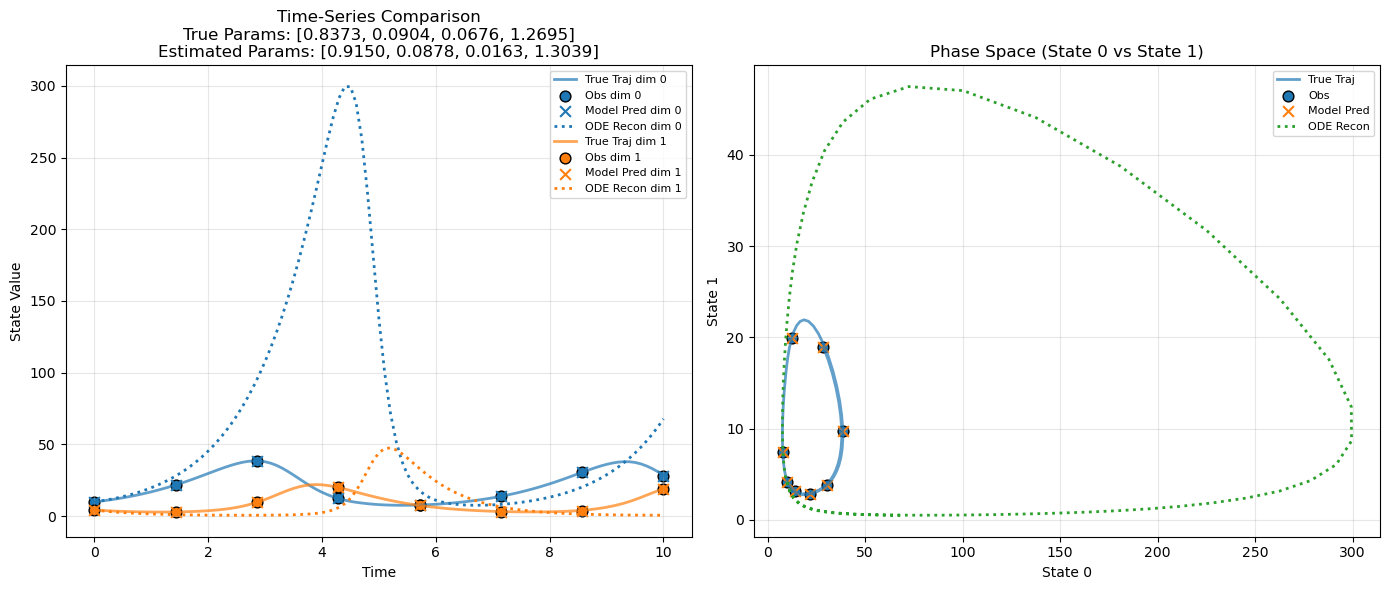

In [99]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def lotka_volterra_eqn(t, x, params):
    """Lotka-Volterra 방정식 함수 (예시)"""
    alpha, beta, delta, gamma = params
    dxdt = alpha * x[0] - beta * x[0] * x[1]
    dydt = delta * x[0] * x[1] - gamma * x[1]
    return [dxdt, dydt]

def reconstruct_trajectory(x0, est_params, t_full):
    """
    주어진 초기 조건(x0)와 추정된 파라미터(est_params)를 사용하여, 
    full time grid t_full에 대해 ODE를 풀어 trajectory를 재구성합니다.
    여기서는 lotka_volterra_eqn을 사용합니다.
    """
    sol = solve_ivp(
        fun=lambda t, x: lotka_volterra_eqn(t, x, est_params),
        t_span=(t_full[0], t_full[-1]),
        t_eval=t_full,
        vectorized=False,
        y0=x0
    )
    return sol

def plot_sample_trajectory(sample_row, model, device='cuda'):
    """
    하나의 샘플에 대해 평가 결과를 시각화합니다.
    
    - sample_row: DataFrame의 한 row (dict)로, 다음 키들을 포함:
         'times': 관측 시간 grid (리스트, 예: t_obs)
         'state_0', 'state_1', ...: 각 state의 noisy 관측 시계열 (리스트)
         'true_trajectory': full ground truth trajectory (리스트 of lists, shape: (T_full, state_dim))
         'x0': 초기 조건 (리스트)
         'params': ground truth 파라미터 (리스트)
    - model: 학습된 모델
    - device: 'cuda' 혹은 'cpu'
    """
    # 1. 데이터 추출 및 전처리
    t_obs = np.array(sample_row['times'])  # 관측 시점 (예: T_obs 길이)
    state_dim = len(sample_row['x0'])
    obs = np.stack([sample_row[f'state_{d}'] for d in range(state_dim)], axis=1)  # (T_obs, state_dim)
    true_traj = np.array(sample_row['true_trajectory'])  # (T_full, state_dim)
    x0 = np.array(sample_row['x0'])
    true_params = np.array(sample_row['params'])
    
    # parameter를 소수 넷째자리로 반올림한 문자열 생성
    true_params_str = ", ".join([f"{p:.4f}" for p in true_params])
    
    # full time grid 재구성 (true trajectory의 길이에 맞게)
    T_full = true_traj.shape[0]
    # 여기서는 t_obs[0]과 t_obs[-1]를 기준으로 full time grid를 구성
    t_full = np.linspace(t_obs[0], t_obs[-1], T_full)
    
    # 2. 모델 예측 (입력: (B, T_obs, state_dim))
    x_obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        pred_obs_tensor, cond = model(x_obs_tensor)
    pred_obs = pred_obs_tensor.squeeze(0).cpu().numpy()  # (T_obs, state_dim)
    est_params = cond.squeeze(0).cpu().numpy()           # (latent_dim,)
    # 추정된 파라미터도 반올림하여 문자열로 변환 (latent_dim과 실제 parameter dimension이 다를 수 있음에 주의)
    est_params_str = ", ".join([f"{p:.4f}" for p in est_params])
    
    # 3. ODE 재구성을 통해 full trajectory 재생성
    sol_est = reconstruct_trajectory(x0, est_params, t_full)
    recon_traj = sol_est.y.T  # (T_full, state_dim)
    
    # 4. 플롯 생성: 1행 2열 subplot
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # (A) Time-Series Comparison: 왼쪽 subplot
    for d in range(state_dim):
        # ground truth trajectory (full time grid, solid line)
        axs[0].plot(t_full, true_traj[:, d], label=f"True Traj dim {d}", color=f"C{d}", linewidth=2, alpha=0.7)
        # 관측치 (scatter, t_obs)
        axs[0].scatter(t_obs, obs[:, d], label=f"Obs dim {d}", color=f"C{d}", marker='o', edgecolor='black', s=60)
        # 모델 예측 (모델 reconstruction, t_obs, marker 'x')
        axs[0].scatter(t_obs, pred_obs[:, d], label=f"Model Pred dim {d}", color=f"C{d}", marker='x', s=60)
        # ODE 재구성 trajectory (dotted line)
        axs[0].plot(t_full, recon_traj[:, d], label=f"ODE Recon dim {d}", color=f"C{d}", linestyle=':', linewidth=2)
    
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("State Value")
    axs[0].set_title(f"Time-Series Comparison\nTrue Params: [{true_params_str}]\nEstimated Params: [{est_params_str}]")
    axs[0].legend(fontsize=8, loc="upper right")
    axs[0].grid(alpha=0.3)
    
    # (B) Phase Space Comparison: 오른쪽 subplot (state0 vs. state1)
    if state_dim >= 2:
        # 실제 phase space: ground truth trajectory (solid line)
        axs[1].plot(true_traj[:, 0], true_traj[:, 1], label="True Traj", color="C0", linewidth=2, alpha=0.7)
        # 관측치: scatter
        axs[1].scatter(obs[:, 0], obs[:, 1], label="Obs", color="C0", marker='o', s=60, edgecolor='black')
        # 모델 예측: phase space (model의 예측치를 t_obs 기준 scatter 혹은 선)
        axs[1].scatter(pred_obs[:, 0], pred_obs[:, 1], label="Model Pred", color="C1", marker='x', s=60)
        # ODE 재구성: phase space (dotted line)
        axs[1].plot(recon_traj[:, 0], recon_traj[:, 1], label="ODE Recon", color="C2", linestyle=':', linewidth=2)
        
        axs[1].set_xlabel("State 0")
        axs[1].set_ylabel("State 1")
        axs[1].set_title("Phase Space (State 0 vs State 1)")
        axs[1].legend(fontsize=8, loc="upper right")
        axs[1].grid(alpha=0.3)
    else:
        axs[1].text(0.5, 0.5, "Phase space unavailable (state_dim < 2)",
                    horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
# 예시 사용:
# test_df는 convert_npz_to_dataframe()으로 생성한 DataFrame
sample_idx = 4  # 평가할 샘플 인덱스 선택
sample_row = test_df.iloc[sample_idx].to_dict()
plot_sample_trajectory(sample_row, trained_model, device='cuda')

In [101]:
import torch
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lotka_volterra_eqn(t, x, params):
    """
    Lotka-Volterra 방정식.
        dx/dt = alpha*x - beta*x*y
        dy/dt = delta*x*y - gamma*y
    """
    alpha, beta, delta, gamma = params
    dxdt = alpha * x[0] - beta * x[0] * x[1]
    dydt = delta * x[0] * x[1] - gamma * x[1]
    return [dxdt, dydt]

def reconstruct_trajectory(x0, est_params, t_full):
    """
    주어진 초기 조건(x0)와 추정된 파라미터(est_params)를 이용해,
    t_full 시간 그리드에 대해 ODE solver를 사용하여 trajectory를 재구성합니다.
    여기서는 Lotka-Volterra 예시 함수(lotka_volterra_eqn)를 사용합니다.
    """
    sol = solve_ivp(
        fun=lambda t, x: lotka_volterra_eqn(t, x, est_params),
        t_span=(t_full[0], t_full[-1]),
        t_eval=t_full,
        vectorized=False,
        y0=x0
    )
    return sol

def compute_rmse(true_traj, recon_traj):
    """
    두 trajectory (각각 (T, D) shape)에 대해 RMSE를 계산합니다.
    """
    return np.sqrt(np.mean((true_traj - recon_traj)**2))

def evaluate_trajectory_error(data_df, model, device='cuda'):
    """
    DataFrame 형식의 테스트 데이터를 이용해,
    각 샘플에 대해 true trajectory와 모델로부터 재구성한 trajectory 간의 오차(RMSE)를 계산합니다.
    
    Args:
        data_df (pd.DataFrame): 각 샘플에 대해, 'times', 'true_trajectory', 'x0', 'params', 그리고 noisy 시계열 정보가 포함된 DataFrame.
        model: 학습된 모델. 모델은 noisy observations를 받아 (predicted observations, condition) 을 출력한다고 가정.
        device (str): 'cuda' 혹은 'cpu'
        
    Returns:
        avg_error: 전체 데이터셋의 평균 RMSE.
        errors: 리스트, 각 샘플별 RMSE.
    """
    model.eval()
    errors = []
    # 각 샘플에 대해
    for idx, row in data_df.iterrows():
        # 1. 데이터 추출
        t_obs = np.array(row['times'])              # 관측 시점 (T_obs,)
        state_dim = len(row['x0'])
        true_traj = np.array(row['true_trajectory'])  # (T_full, state_dim)
        x0 = np.array(row['x0'])
        # ground truth parameter (그러나 여기서는 ODE 재구성에 사용하지 않고, 모델의 추정을 검증함)
        # true_params = np.array(row['params'])
        
        # 2. full time grid 생성 : true trajectory의 길이(T_full)와 t_obs 시작 및 끝을 기준으로.
        T_full = true_traj.shape[0]
        t_full = np.linspace(t_obs[0], t_obs[-1], T_full)
        
        # 3. 모델 예측: noisy 관측을 이용하여 estimated parameter 추출.
        # 관측 시계열은 (T_obs, state_dim) 배열; 모델 입력은 (B, T_obs, state_dim)
        obs = np.stack([row[f'state_{d}'] for d in range(state_dim)], axis=1)
        x_obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            _, cond = model(x_obs_tensor)
        est_params = cond.squeeze(0).cpu().numpy()  # (latent_dim,)
        
        # 4. ODE 재구성을 통해 trajectory 생성
        sol_est = reconstruct_trajectory(x0, est_params, t_full)
        recon_traj = sol_est.y.T  # (T_full, state_dim)
        
        # 5. RMSE 계산 (true_traj와 recon_traj 비교)
        error = compute_rmse(true_traj, recon_traj)
        errors.append(error)
    
    avg_error = np.mean(errors)
    print(f"평균 재구성 RMSE: {avg_error:.4f}")
    return avg_error, errors

# 예시 사용:
# test_df: 테스트 데이터를 담은 DataFrame (convert_npz_to_dataframe()의 결과)
avg_rmse, rmse_list = evaluate_trajectory_error(test_df, trained_model, device='cuda')


평균 재구성 RMSE: 142.3336
